# Polymer dynamics example

First run the example to train and save the trained model
```shell
cd ./examples/polymer_dynamics
python polymer_dynamics.py
```

The results will be saved to a path in `./outputs/...` that appropriately time-stamped.

The rest of the notebook will perform checking analysis on the outputs.

In [1]:
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# Read saved model and config

In [2]:
from omegaconf import OmegaConf
from polymer_dynamics import build_model
from datasets import load_dataset

In [3]:
path = "outputs/2025_01_15-11_16_49"
config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
dataset = load_dataset(config.data.repo, split="train")
dataset = dataset.with_format("jax")
model_template = build_model(config, dataset)
trained_model = eqx.tree_deserialise_leaves(os.path.join(path, "model.eqx"), model_template)

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

c:\Users\sohwy\AppData\Local\pypoetry\Cache\virtualenvs\onsagernet-PbgjltZG-py3.12\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sohwy\.cache\huggingface\hub\datasets--MLDS-NUS--Wi_10. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00005.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

test_fast-00000-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_fast-00001-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_fast-00002-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_fast-00003-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_slow-00000-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_slow-00001-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_slow-00002-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_slow-00003-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_medium-00000-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_medium-00001-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_medium-00002-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test_medium-00003-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating test_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test_medium split:   0%|          | 0/500 [00:00<?, ? examples/s]

## Predictions

We first test the predictions of the mean, standard deviation and the unfolding time distribution.

Load test data

In [4]:
test_data_fast = load_dataset(config.data.repo, split="test_fast").with_format("jax")
test_data_medium = load_dataset(config.data.repo, split="test_medium").with_format("jax")
test_data_slow = load_dataset(config.data.repo, split="test_slow").with_format("jax")
test_x = [test_data_fast["x"], test_data_medium["x"], test_data_slow["x"]]
test_args = [test_data_fast["args"], test_data_medium["args"], test_data_slow["args"]]

Transform data into reduced coordinates using the trained encoder

In [5]:
encoder_vmapped = jax.jit(jax.vmap(jax.vmap(trained_model.encoder)))
test_z = [encoder_vmapped(d) for d in test_x]

In [6]:
print(test_data_fast['t'][0])
print(dataset['t'][0])
print(config.dt)

[[0.    ]
 [0.0005]
 [0.001 ]
 ...
 [0.499 ]
 [0.4995]
 [0.5   ]]
[[0.    ]
 [0.0005]
 [0.001 ]
 ...
 [0.499 ]
 [0.4995]
 [0.5   ]]
0.0005


Generate the predictions

In [7]:
from examples.utils.sde import SDEIntegrator
integrator = SDEIntegrator(model=trained_model.sde, state_dim=config.reduced_dim)

In [8]:
num_runs = test_data_fast.shape[0]

keys  = jr.split(jr.PRNGKey(config.model.seed + 123), 3)
predicted_trajectories = []

for key, traj in zip(keys, test_z):
    init_conditions = jnp.repeat(traj[0, 0, :][None, :], num_runs, axis=0)
    bm_keys = jr.split(key, num_runs)
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=config.dt * test_z[0].shape[1],
        dt=config.dt,
        args=[config.temperature],
    )
    predicted_trajectories.append(sol.ys)

We can quickly compare the trajectories

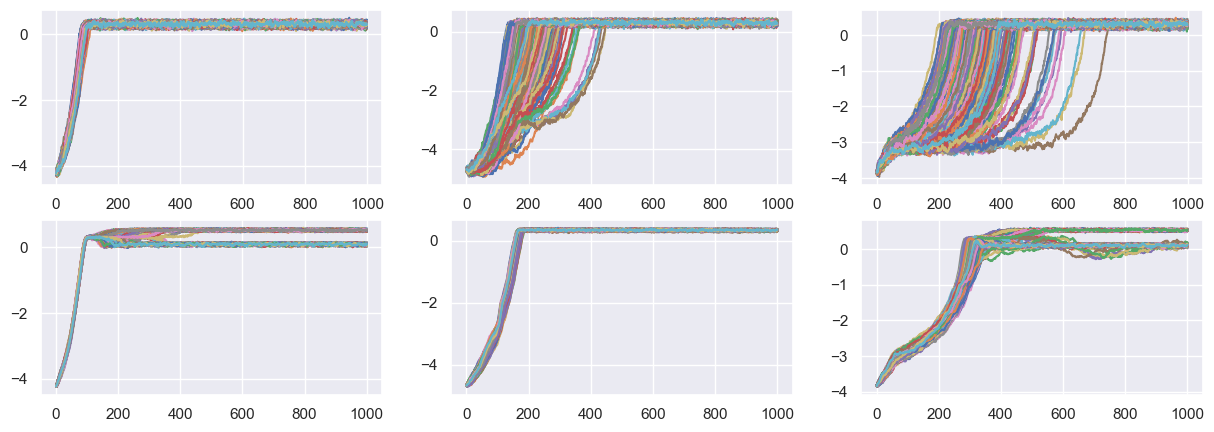

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

for a, traj in zip(ax[0], test_z):
    for i in range(num_runs):
        a.plot(traj[i, :, 0])

for a, traj in zip(ax[1], predicted_trajectories):
    for i in range(num_runs):
        a.plot(traj[i, :, 0])

Compare the statistics

In [10]:
@jax.jit
def compute_unfolding_time(traj):
    unfolded_extension = traj[:, -1, 0]
    threshold = 0.95 * unfolded_extension
    first_index = jnp.argmin(traj[:, :, 0] <= threshold[:, None], axis=1)
    return first_index

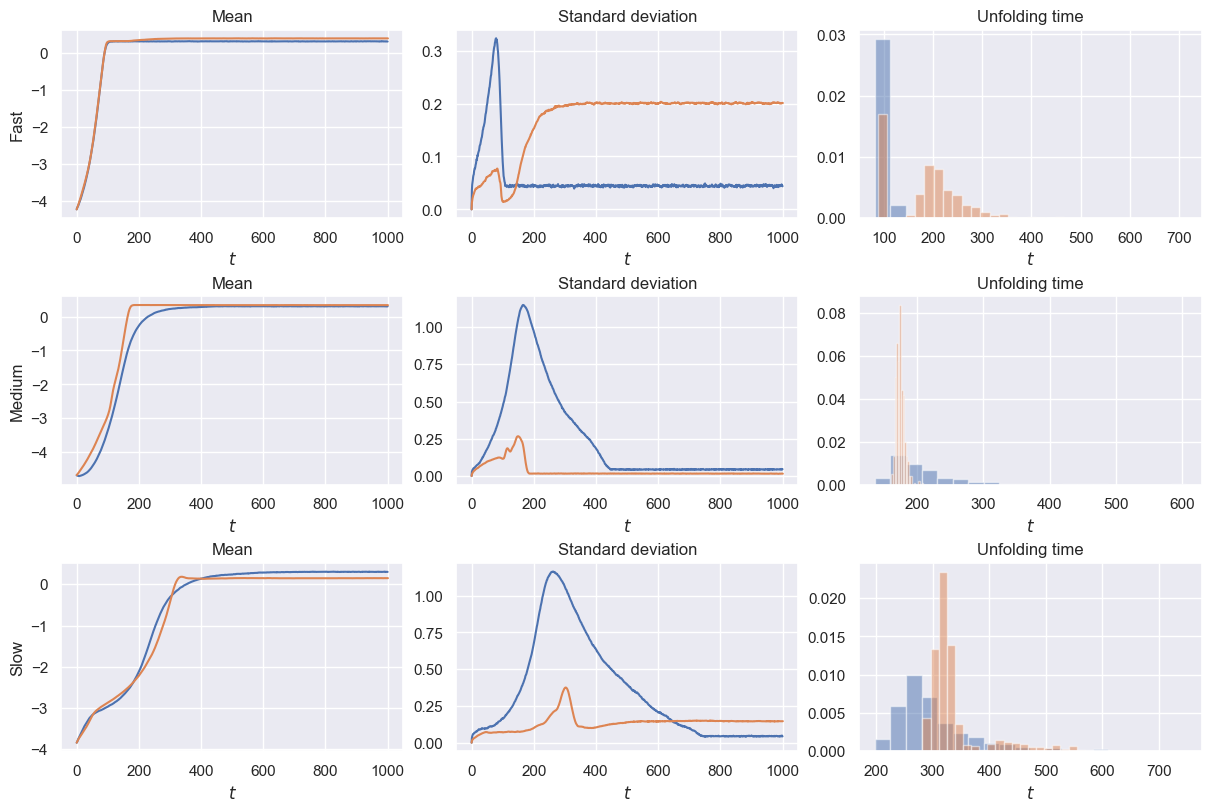

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8), layout="constrained")

for a, true, pred in zip(ax, test_z, predicted_trajectories):
    true_mean = jnp.mean(true, axis=0)
    pred_mean = jnp.mean(pred, axis=0)

    a[0].plot(true_mean[:, 0], label="True")
    a[0].plot(pred_mean[:, 0], label="Pred")
    a[0].set_title("Mean")

    true_std = jnp.std(true, axis=0)
    pred_std = jnp.std(pred, axis=0)

    a[1].plot(true_std[:, 0], label="True")
    a[1].plot(pred_std[:, 0], label="Pred")
    a[1].set_title("Standard deviation")

    true_unfolding_time = compute_unfolding_time(true)
    pred_unfolding_time = compute_unfolding_time(pred)

    a[2].hist(true_unfolding_time, label="True", alpha=0.5, density=True, bins=20)
    a[2].hist(pred_unfolding_time, label="Pred", alpha=0.5, density=True, bins=20)
    a[2].set_title("Unfolding time")

for a in ax.flatten():
    a.set_xlabel(r"$t$")

for a, label in zip(ax[:, 0], ["Fast", "Medium", "Slow"]):
    a.set_ylabel(label)

## Potential landscape

Next, let us compare the potential landscape.

As described in the paper, we will visualise 2D projections of the 3D potential defined by
$$
    v(z_1, z_2) := \inf_{z_3} V(z_1, z_2, z_3)
$$
We know from large deviations theory that for sufficiently low temperatures, this approximation is valid.

In [11]:
z1_min, z1_max = -3, 1
z2_min, z2_max = -2, 2
z3_min, z3_max = -6, 6
num_samples_aux_dimension = 128  # number of samples to take infimum over

In [12]:
def V(z1, z2, z3):
    z = jnp.array([z1, z2, z3])
    return trained_model.sde.potential(z, [config.temperature])

In [13]:
@jax.vmap
@jax.jit
def V_12(z1, z2):
    z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range))

@jax.vmap
@jax.jit
def V_13(z1, z3):
    z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3))

@jax.vmap
@jax.jit
def V_23(z2, z3):
    z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3))

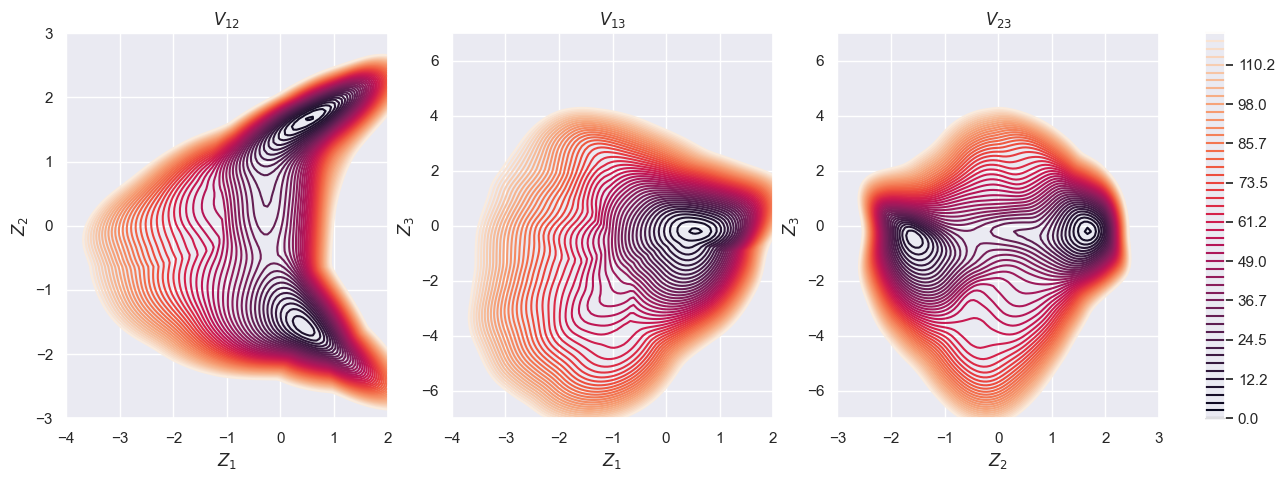

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

num_grid = 100
num_levels = 50
off_set = 1.0
level_start = 0.0
level_end = 120.0

custom_levels = jnp.linspace(level_start, level_end, num_levels)

# Define the range and number of points in each dimension
z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

# V12
Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
V12_grid = V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
contour1 = ax[0].contour(Z1, Z2, V12_grid, levels=custom_levels)
ax[0].set_title(r'$V_{12}$')
ax[0].set_xlabel(r'$Z_1$')
ax[0].set_ylabel(r'$Z_2$')

# V13
Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
contour2 = ax[1].contour(Z1, Z3, V13_grid, levels=custom_levels)
ax[1].set_title(r'$V_{13}$')
ax[1].set_xlabel(r'$Z_1$')
ax[1].set_ylabel(r'$Z_3$')

# V23
Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
contour3 = ax[2].contour(Z2, Z3, V23_grid, levels=custom_levels)
ax[2].set_title(r'$V_{23}$')
ax[2].set_xlabel(r'$Z_2$')
ax[2].set_ylabel(r'$Z_3$')

cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

# Physical meaning of the closure coordinates

Finally, we confirm the conclusion in the paper that the closure coordinates are highly correlated with end-to-end distance and foldedness, respectively.

In [15]:
@jax.jit
@jax.vmap
@jax.vmap
def end_to_end_distance(x: jnp.ndarray) -> float:
    r"""Computes the end-to-end distance of a polymer chain.

    We assume that the polymer chain is represented by a 900 dimensional vector,
    where each triplet of coordinates represents the position of a monomer.

    This function then computes
    $$
        \text{end-to-end distance} = |x_{\text{end}} - x_{\text{start}}|
    $$

    Args:
        x (jnp.ndarray): 900 dimensional vector representing the polymer chain.

    Returns:
        float: end-to-end distance of the polymer chain.
    """
    return jnp.abs(x[::3][-1] - x[::3][0])

@jax.jit
@jax.vmap
@jax.vmap
def foldedness(x : jnp.ndarray) -> float:
    """Computes the foldedness of a polymer chain.

    We assume that the polymer chain is represented by a 900 dimensional vector,
    where each triplet of coordinates represents the position of a monomer.

    This function then computes
    $$
        \text{foldedness} = |x_{\text{end}} + x_{\text{start}}|
    $$

    Args:
        x (jnp.ndarray): 900 dimensional vector representing the polymer chain.

    Returns:
        float: foldedness of the polymer chain.
    """
    return jnp.abs(x[::3][-1] + x[::3][0])

In [16]:
train_x = dataset["x"]
eted_x = end_to_end_distance(train_x)
foldedness_x = foldedness(train_x)
data_z = encoder_vmapped(train_x)

Text(0, 0.5, '$\\text{Foldedness}$')

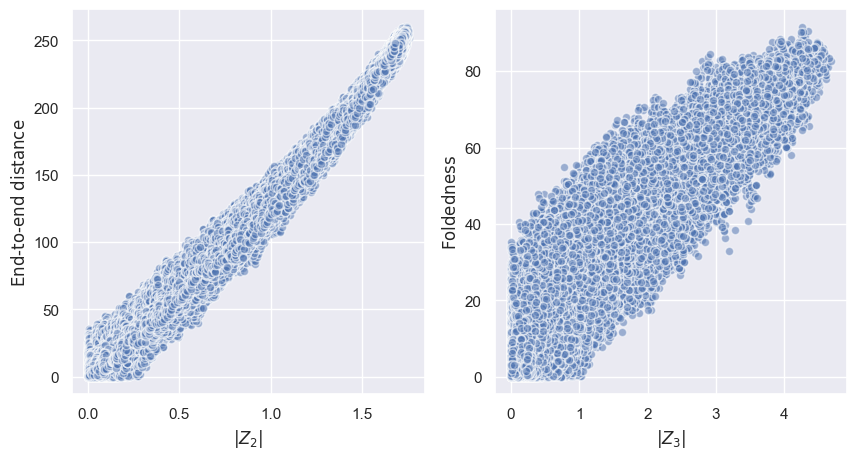

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(jnp.abs(data_z[:, :, 1].ravel()), eted_x.ravel(), alpha=0.5, edgecolors='w')
ax[1].scatter(jnp.abs(data_z[:, :, 2].ravel()), foldedness_x.ravel(), alpha=0.5, edgecolors='w')

ax[0].set_xlabel(r'$|Z_2|$')
ax[0].set_ylabel(r'$\text{End-to-end distance}$')

ax[1].set_xlabel(r'$|Z_3|$')
ax[1].set_ylabel(r'$\text{Foldedness}$')